In tutorial 1, we considered why our Constant _Regularization_scheme was sub-optimal. Diffferent regions of the source demand different levels of regularization, motivating a _Regularization_scheme which adapts to the reconstructed source’s surface brightness.

This raises the same question as before, how do we adapt our _Regularization_scheme to the source before we’ve reconstructed it? Just like in the last tutorial, we’ll use a model image of a strongly lensed source from a previous phase of the pipeline that we’ve begun calling the ‘hyper-galaxy-image’.

In [1]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('/home/carlos/Documents/Dados Projeto/ESO325/Results/ESO325 MGE and JAM (07-07-20)/Codes/JAM Input.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solLum/u.pc**2)                         #Surface Luminosity in L_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Lum_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                  #Total Luminosity per gaussian component




#Defining inputs for the integral bellow
ML = 2.75*(u.solMass/u.solLum)                                 #Mass-to-light ratio in kg/L_sun
i = np.deg2rad(80)*u.rad                                       #Inclination angle in rad
M0 = ML*Lum_mge                                                #Mass per gaussian component in kg
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad

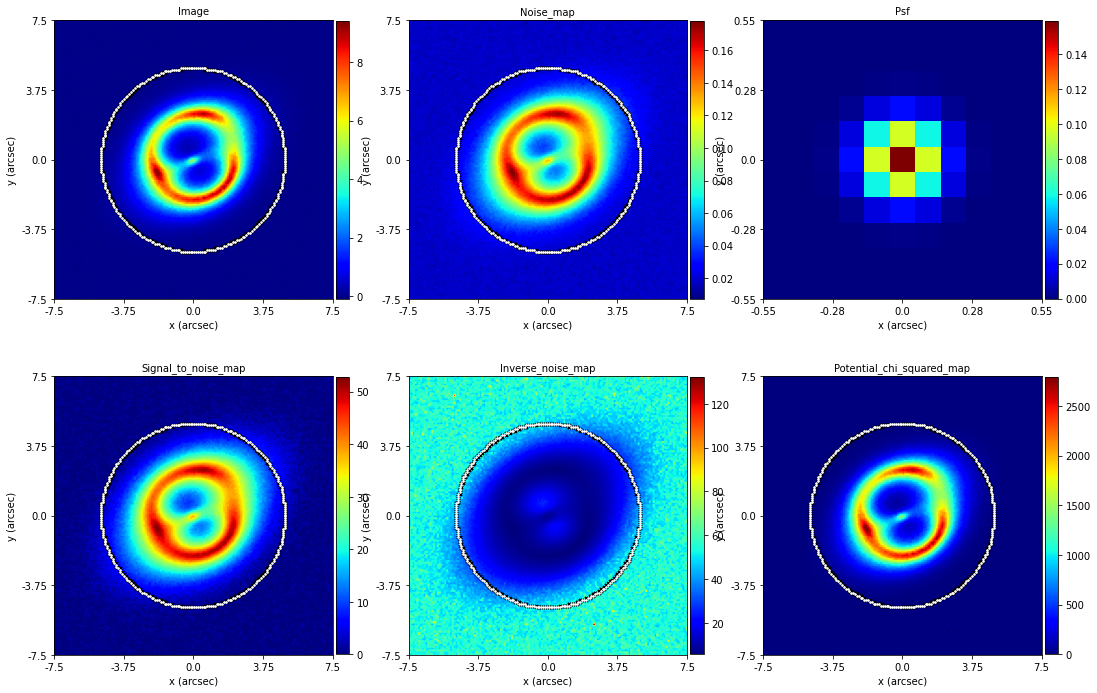

In [3]:

dataset_type = "MGE"
dataset_name = "Data"
dataset_path = f"{workspace_path}/howtolens/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageUnits.fits",
    noise_map_path=f"{dataset_path}/NoiseUnits.fits",
    psf_path=f"{dataset_path}/PSFUnits.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1, radius=5
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)

Next, we’re going to fit the image using our magnification based grid. To perform the fits, we’ll use a convenience function to fit the lens data we simulated above.

In [4]:
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.MGE(centre=(0.0, 0.0), einstein_radius=1.6)
    mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
    lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


Next, we’ll use the magnification based source to fit this data.

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


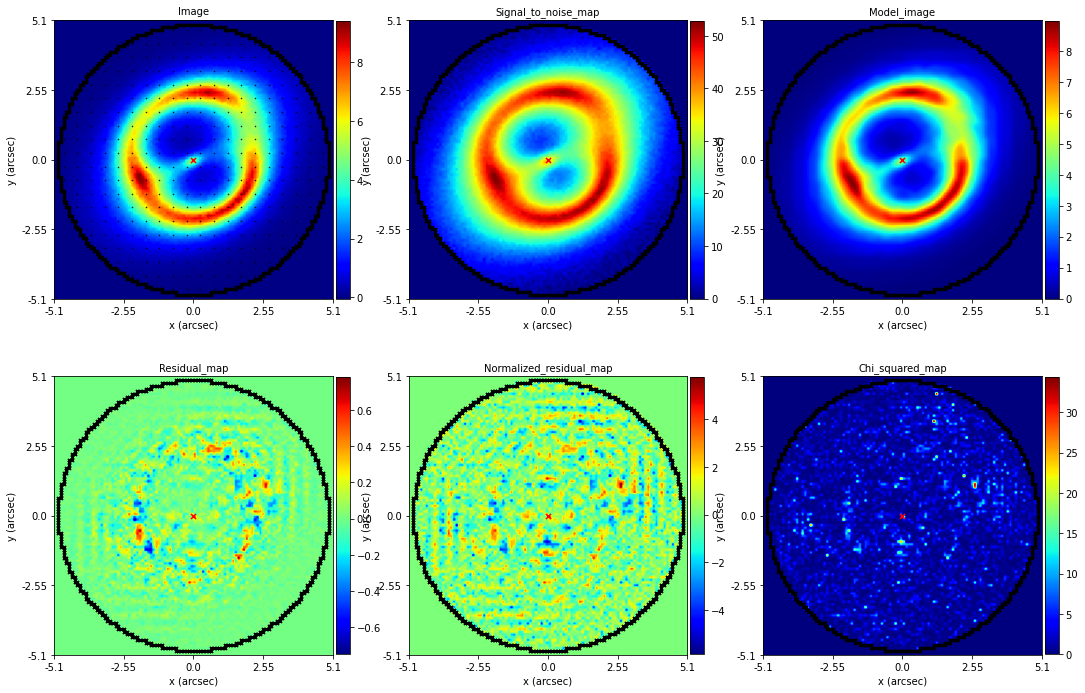

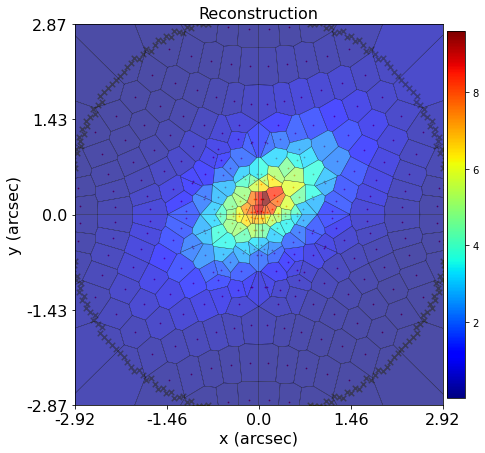

Evidence using adaptive _Regularization_=  5768.871028134055
97.9738237769925


In [15]:
time = clock()

source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=3.3),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence

print(clock() - time)

Okay, so the inversion’s fit looks just like it did in the previous tutorials. Lets quickly remind ourselves that the effective regularization_coefficient of each source pixel is our input coefficient value of 3.3

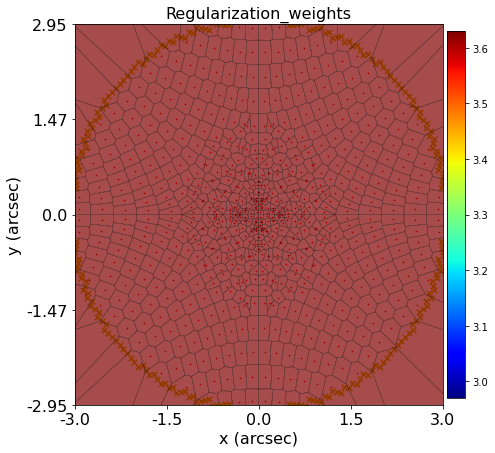

In [6]:
aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

Lets now look at adaptive _Regularization_in action, by setting up a hyper-galaxy-image and using the ‘AdaptiveBrightness’ _Regularization_scheme. This introduces additional hyper-galaxy-parameters, that I’ll explain next.

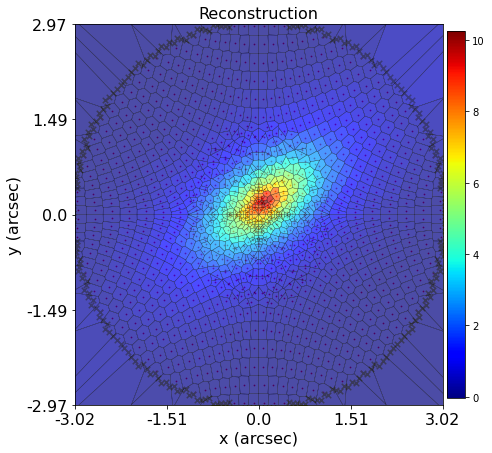

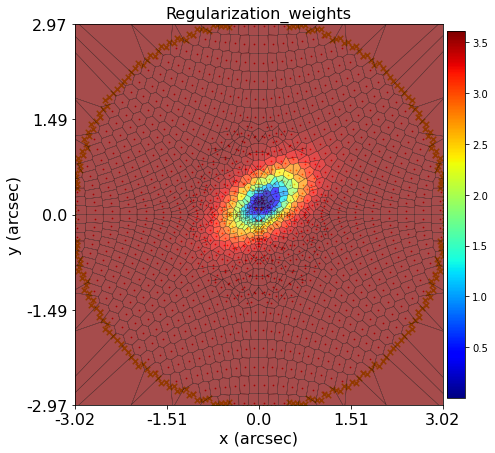

113.03130904999853


In [7]:
time = clock()

hyper_image = fit.model_image.in_1d_binned

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(40, 40)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.005, outer_coefficient=1.9, signal_scale=3.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

print(clock() - time)

So, as expected, we now have a variable Regularization scheme. The _Regularization_of the source’s brightest regions is much lower than that of its outer regions. As discussed before, this is what we want. Lets quickly check that this does, indeed, increase the Bayesian log evidence:

In [8]:
print("Evidence using constant _Regularization_= ", frist_log)
print("Evidence using adaptive _Regularization_= ", fit.log_evidence)

Evidence using constant _Regularization_=  7652.410267000367
Evidence using adaptive _Regularization_=  7322.872176109058


Yep! Of course, combining the adaptive _Pixelization_and _Regularization_will only further benefit our lens modeling!

However, as shown below, we don’t fit the source as well as the morphology based Pixelization did in the last chapter. This is because although the adaptive Regularization scheme improves the fit, the magnification based Pixelization simply does not have sufficient resolution to resolve the source’s cuspy central LightProfile.

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


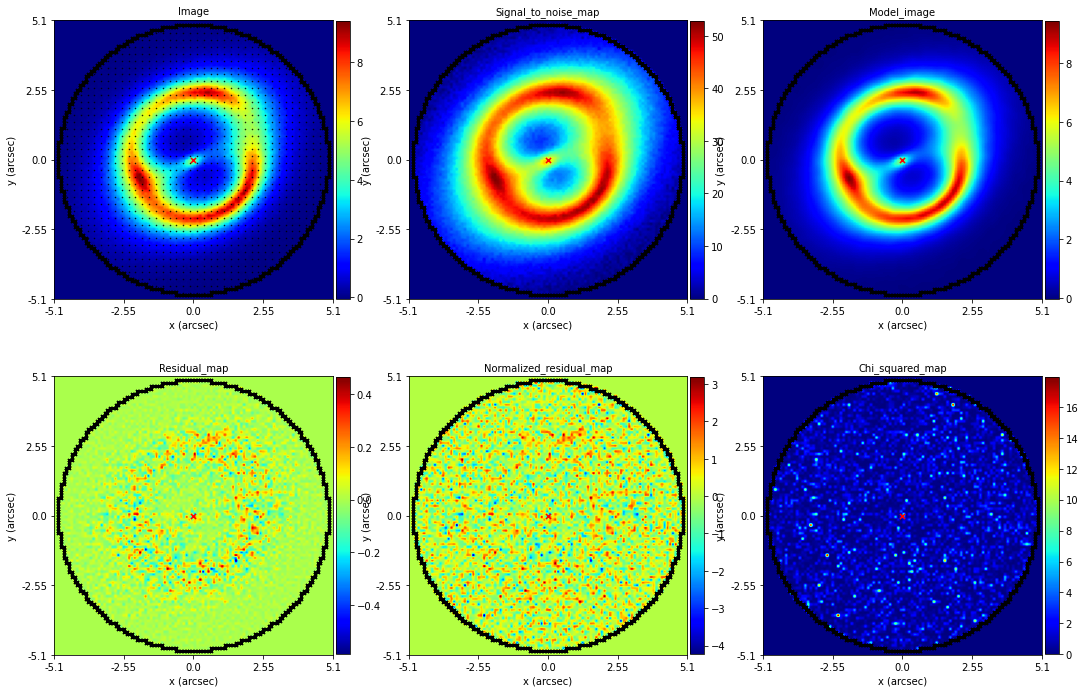

In [9]:
aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

How does adaptive regularization work?

For every source-pixel, we have a mapping between that pixel and a set of pixels in the hyper-galaxy-image. Therefore, for every source-pixel, if we sum the values of all hyper-galaxy-image pixels that map to it we get an estimate of how much of the lensed source’s signal we expect will be reconstructed. We call this each pixel’s ‘pixel signal’.

If a source-pixel has a higher pixel-signal, we anticipate that it’ll reconstruct more flux and we use this information to regularize it less. Conversely, if the pixel-signal is close to zero, the source pixel will reconstruct near-zero flux and _Regularization_will smooth over these pixels by using a high regularization_coefficient.

This works as follows:

    For every source pixel, compute its pixel-signal, the summed flux of all corresponding image-pixels in the hyper-galaxy-image.
    Divide every pixel-signal by the number of image-pixels that map directly to that source-pixel. In doing so, all pixel-signals are ‘relative’. This means that source-pixels which by chance map to more image-pixels than their neighbors will not have a higher pixel-signal, and visa versa. This ensures the specific Pixelization does impact the adaptive Regularization pattern.
    Divide the pixel-signals by the maximum pixel signal so that they range between 0.0 and 1.0.
    Raise these values to the power of the hyper-galaxy-parameter signal_scale. For a signal_scale of 0.0, all pixels will therefore have the same final pixel-scale. As the signal_scale increases, a sharper transition of pixel-signal values arises between regions with high and low pixel-signals.
    Compute every source pixel’s effective regularization_coefficient as:

(inner_coefficient * pixel_signals + outer_coefficient * (1.0 - pixel_signals)) ** 2.0

This uses two regularization_coefficients, one which is applied to pixels with high pixel-signals and one to pixels with low pixel-signals. Thus, pixels in the inner regions of the source may be given a lower level of _Regularization_than pixels further away, as desired.

Thus, we now adapt our Regularization scheme to the source’s surface brightness. Where its brighter (and therefore has a steeper flux gradient) we apply a lower level of Regularization than further out. Furthermore, in the edges of the source-plane where no source-flux is present we will assume a high regularization_coefficients that smooth over all source-pixels.

Try looking at a couple of extra solutions which use with different inner and outer regularization_coefficients or signal scales. I doubt you’ll notice a lot change visually, but the log evidence certainly has a lot of room for manoveur with different values.

You may find solutions that raise an ‘InversionException’. These solutions mean that the matrix used during the linear algebra calculation was ill-defined, and could not be inverted. These solutions are removed by PyAutoLens during lens modeling.

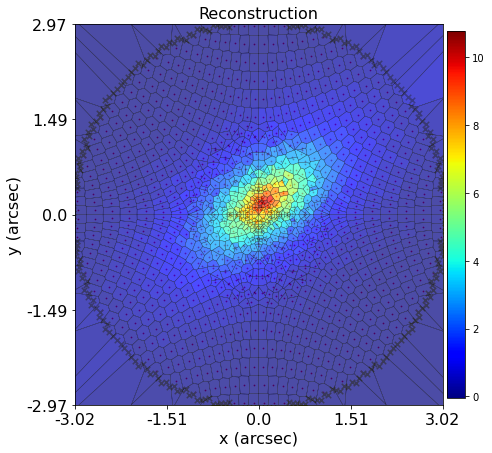

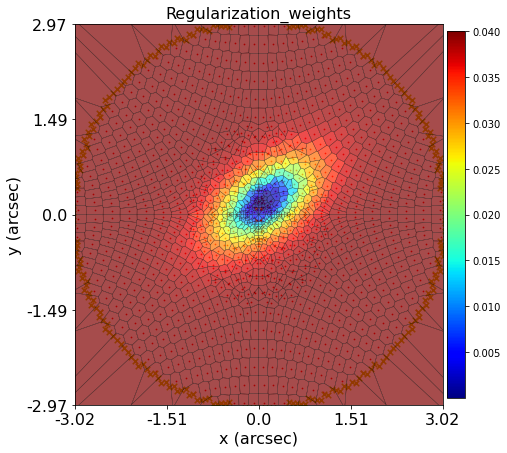

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


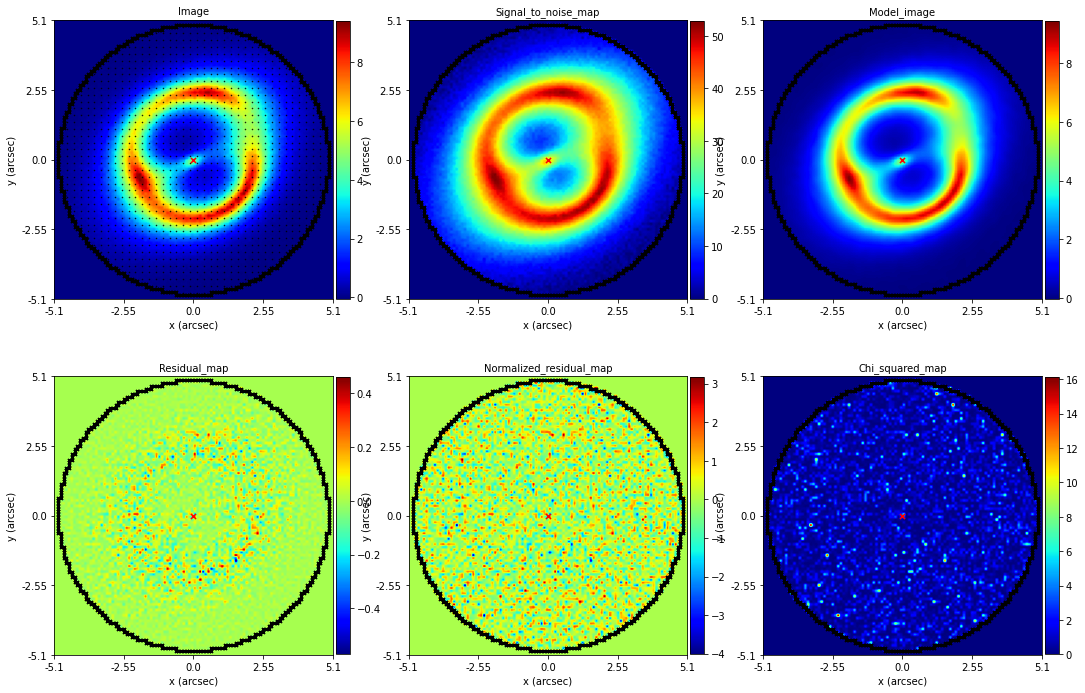

Evidence using adaptive _Regularization_=  5378.13453735642
115.07958667700586


In [10]:
time = clock()

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(40, 40)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)

print(clock() - time)

#######################################################################################################################

In [11]:
time = clock()

mass_profile = al.mp.MGE(centre=(0.0, 0.0), einstein_radius=1.6)
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print(clock() - time)

92.02510430400434


In [12]:
time = clock()

rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

print(clock() - time)

1.2670090249885106


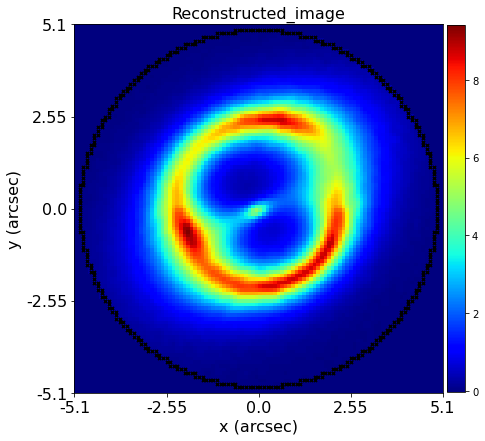

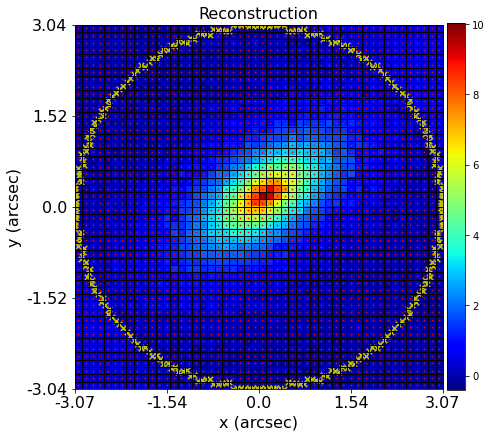

0.6688522579934215


In [13]:
time = clock()

aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_grid=False)
)

print(clock() - time)

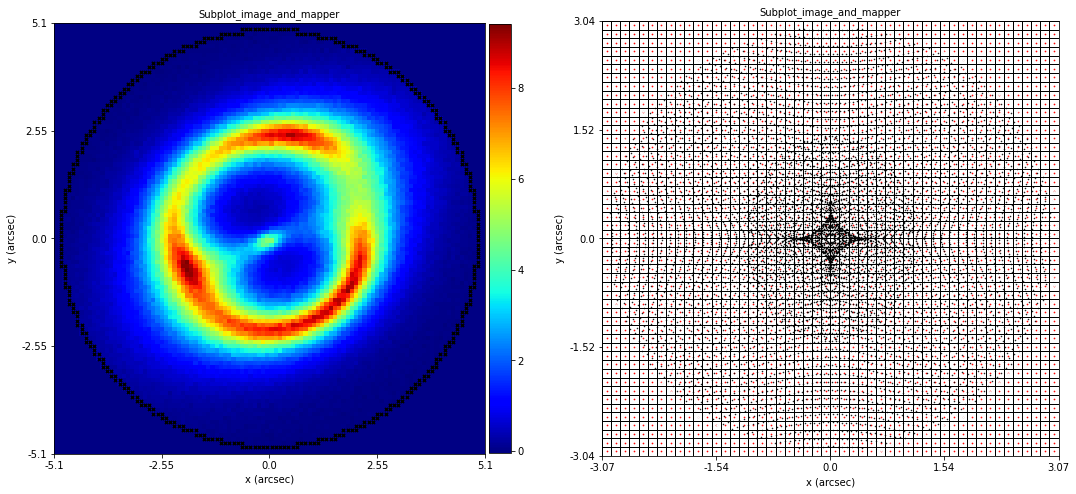

In [14]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

In [1]:
tracer.galaxies

NameError: name 'aplt' is not defined